### Libraries

In [38]:
# ! pip install stanza

In [39]:
import pandas as pd
import numpy as np
import stanza
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Load Data

In [40]:
PATH = 'data/'
PATH = PATH.rstrip('/')

In [41]:
df_train = pd.read_csv(PATH + '/train.csv')
df_train.columns = ['index', 'comment', 'rate']

df_eval = pd.read_csv(PATH + '/eval.csv')
df_eval.columns = ['index', 'comment', 'rate']

df_train.head(5)

,index,comment,rate
0,2587,پردازنده های Core i5 و Core i3 نیز ذاتا دو هست...,0.0
1,22591,سلام به دوستای عزیزم \r\nعزاداری هاتون قبول باشه,1.0
2,141037,کلا پولتون رو دور نریزیزد,-1.0
3,58593,از صمیم قلب امیدوارم دایانا با کارن بمونه و پو...,1.0
4,5712,آنطور که اپل ادعا می کند آیپاد شافل دارای طراح...,1.0


### Data Info

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    800 non-null    int64  
 1   comment  800 non-null    object 
 2   rate     800 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.9+ KB


In [43]:
df_train['rate'].describe()

count    800.000000
mean       0.278625
std        0.712302
min       -1.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: rate, dtype: float64

<AxesSubplot:ylabel='Density'>

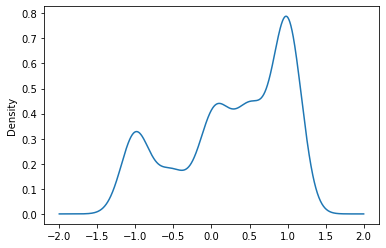

In [44]:
df_train['rate'].plot.kde()

### Add Label Column

In [31]:
## Label
y_train = (df_train['rate'] >= 0).astype(int)
y_eval = (df_eval['rate'] >= 0).astype(int)

In [34]:
# accuracy base line
np.sum(y_train)/len(y_train)

0.7575

### Clean Comments

In [66]:
from hazm import *
import re

In [67]:
normalizer = Normalizer()

In [68]:
stopwords = utils.stopwords_list()

In [69]:
regex = r"\b(?:" + "|".join(map(re.escape, stopwords)) + r")\b"

In [70]:
clean_comment = lambda comment:word_tokenize(re.sub(regex, " ", normalizer.normalize(comment)))

In [71]:
df_train['cleaned_comment'] = df_train['comment'].apply(clean_comment)
df_eval['cleaned_comment'] = df_eval['comment'].apply(clean_comment)

#### Cleaned comments

In [73]:
import stanza

In [78]:
nlp = stanza.Pipeline(lang='fa', processors='tokenize', tokenize_pretokenized=True)

2022-01-07 22:22:21 WARNING: Language fa package default expects mwt, which has been added
2022-01-07 22:22:21 INFO: Loading these models for language: fa (Persian):
| Processor | Package |
-----------------------
| tokenize  | perdt   |
| mwt       | perdt   |

2022-01-07 22:22:21 INFO: Use device: gpu
2022-01-07 22:22:21 INFO: Loading: tokenize
2022-01-07 22:22:21 INFO: Loading: mwt
2022-01-07 22:22:22 INFO: Done loading processors!


In [83]:
df_eval['cleaned_comment_st'] = df_eval['cleaned_comment'].apply(lambda comment:nlp(comment).sentences)

AttributeError: 'list' object has no attribute 'words'

In [82]:
df_eval['cleaned_comment_st']

0      [[\n  {\n    "id": 1,\n    "text": "ک",\n    "...
1      [[\n  {\n    "id": 1,\n    "text": "‌",\n    "...
2      [[\n  {\n    "id": 1,\n    "text": "ط",\n    "...
3      [[\n  {\n    "id": 1,\n    "text": "م",\n    "...
4      [[\n  {\n    "id": 1,\n    "text": "م",\n    "...
                             ...                        
195    [[\n  {\n    "id": 1,\n    "text": "ک",\n    "...
196    [[\n  {\n    "id": 1,\n    "text": "ز",\n    "...
197    [[\n  {\n    "id": 1,\n    "text": "د",\n    "...
198    [[\n  {\n    "id": 1,\n    "text": "ب",\n    "...
199    [[\n  {\n    "id": 1,\n    "text": "ت",\n    "...
Name: cleaned_comment_st, Length: 200, dtype: object

In [72]:
df_train['cleaned_comment'][:2]

0    [پردازنده‌های, Core, i۵, Core, i۳, ذاتا, هسته‌...
1    [سلام, دوستای, عزیزم, عزاداری, هاتون, قبول, باشه]
Name: cleaned_comment, dtype: object

In [10]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=1, max_df =0.95, ngram_range = (1,1), max_features=10000)

train_data_features = vectorizer.fit_transform(cleaned_train_data)

print(train_data_features.shape)


(800, 4522)


In [11]:
## data snooping ALERT: we should transforom not fit again

eval_data_features = vectorizer.transform(cleaned_eval_data)

In [12]:
# show
vectorizer.get_feature_names()[:10]

C:\Users\Sajjad\.conda\envs\Training-Post-Retrieval\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10', '100', '1000', '1080', '1080p', '114gr', '12', '122x87x93', '125', '13']

In [13]:
# Load model

solvers= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_classes = ['multinomial', 'ovr']

model = LogisticRegression(penalty='l2', random_state=0, solver='liblinear', max_iter=1000, multi_class='ovr')
# Train model
model.fit(train_data_features, y_train)


LogisticRegression(max_iter=1000, multi_class='ovr', random_state=0,
                   solver='liblinear')

In [14]:
## evaluation 

y_eval_perd = model.predict(eval_data_features)

In [15]:
print('----- Accuracy Score ----- ')
print(accuracy_score(y_eval, y_eval_perd))
print('----- Confusion Matrix ----- ')
print(confusion_matrix(y_eval, y_eval_perd))
print('----- Classification Report ----- ')
print(classification_report(y_eval, y_eval_perd))


----- Accuracy Score ----- 
0.73
----- Confusion Matrix ----- 
[[  3  52]
 [  2 143]]
----- Classification Report ----- 
              precision    recall  f1-score   support

           0       0.60      0.05      0.10        55
           1       0.73      0.99      0.84       145

    accuracy                           0.73       200
   macro avg       0.67      0.52      0.47       200
weighted avg       0.70      0.73      0.64       200

